# Conformal Prediction according to Slant Distance

First lets try to established a correlation between the size of the bounded boxes and the slant_distance, to see if the box area is easily predictible from the slant distance. 

In [14]:
import os
import pandas as pd
import numpy as np


def calculate_polygon_area(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D):
    return 0.5 * abs(
        x_A*y_B + x_B*y_C + x_C*y_D + x_D*y_A 
        - (y_A*x_B + y_B*x_C + y_C*x_D + y_D*x_A)
    )

# Normalize coordinates for each corner (instead of the bounding box center)
def normalize_coordinates(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, image_width, image_height):
    # Normalisation de chaque coin
    x_A_norm = x_A / image_width
    y_A_norm = y_A / image_height
    x_B_norm = x_B / image_width
    y_B_norm = y_B / image_height
    x_C_norm = x_C / image_width
    y_C_norm = y_C / image_height
    x_D_norm = x_D / image_width
    y_D_norm = y_D / image_height
    
    return x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm


import pandas as pd
import os
import numpy as np

def get_all_slant_bbox_size(folder_path, output_csv="output.csv"): 
    data_list = []
    slant_distances = []  # Liste pour stocker toutes les distances de pente
    seen_entries = set()  # Set pour garder trace des entrées déjà traitées

    # Première passe : collecte des distances de pente pour le calcul de la moyenne et de l'écart-type
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep=";")

            if "slant_distance" in df.columns and df["slant_distance"].notna().any():
                for _, row in df.iterrows():
                    if pd.notna(row.get("slant_distance")):
                        slant_distance_km = row["slant_distance"] * 1.852  # Conversion en kilomètres
                        slant_distances.append(slant_distance_km)

    # Calcul de la moyenne et de l'écart-type des distances de pente
    mean_slant_distance = np.mean(slant_distances)
    std_slant_distance = np.std(slant_distances)

    # Deuxième passe : collecte des informations sur les boîtes englobantes et les distances de pente
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, sep=";")

            if "slant_distance" in df.columns and df["slant_distance"].notna().any():
                for _, row in df.iterrows():
                    if pd.notna(row.get("slant_distance")):
                        image_name = os.path.basename(row["image"])

                        # Crée une clé unique pour chaque ligne (par exemple, nom de l'image + coordonnées)
                        entry_key = (image_name, row["x_A"], row["y_A"], row["x_B"], row["y_B"], row["x_C"], row["y_C"], row["x_D"], row["y_D"])

                        # Vérifie si cette entrée a déjà été vue
                        if entry_key not in seen_entries:
                            # Marquer cette entrée comme traitée
                            seen_entries.add(entry_key)

                            # Normaliser les coins
                            x_A, y_A = row["x_A"], row["y_A"]
                            x_B, y_B = row["x_B"], row["y_B"]
                            x_C, y_C = row["x_C"], row["y_C"]
                            x_D, y_D = row["x_D"], row["y_D"]
                            image_width = row["width"]  # On suppose que vous avez la largeur de l'image
                            image_height = row["height"]  # On suppose que vous avez la hauteur de l'image
                            
                            # Normaliser les coins
                            x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm = normalize_coordinates(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, image_width, image_height)
                            
                            # Calcul de l'aire du polygone (boîte englobante)
                            bbox_area = calculate_polygon_area(x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D)
                            
                            # Conversion de la distance de pente en kilomètres
                            slant_distance_km = row["slant_distance"] * 1.852  # Conversion en kilomètres
                        
                            # Normalisation de la slant distance (Z-score)
                            slant_distance_zscore = (slant_distance_km - mean_slant_distance) / std_slant_distance

                            # Ajout des résultats à la liste
                            data_list.append([image_name, slant_distance_km, slant_distance_zscore, bbox_area, x_A, y_A, x_B, y_B, x_C, y_C, x_D, y_D, x_A_norm, y_A_norm, x_B_norm, y_B_norm, x_C_norm, y_C_norm, x_D_norm, y_D_norm, file])
    
    # Conversion de la liste en DataFrame et sauvegarde dans un fichier CSV
    output_df = pd.DataFrame(data_list, columns=["image", "slant_distance", "slant_distance_zscore", "bbox_area", "x_A", "y_A", "x_B", "y_B", "x_C", "y_C", "x_D", "y_D", "x_A_norm", "y_A_norm", "x_B_norm", "y_B_norm", "x_C_norm", "y_C_norm", "x_D_norm", "y_D_norm", 'file'])
    output_df.to_csv(output_csv, index=False)
    print(f"Résultats enregistrés dans {output_csv}")
    
    return output_df


In [15]:
get_all_slant_bbox_size("/home/aws_install/conformal_prediction/csv_test")

Résultats enregistrés dans output.csv


,image,slant_distance,slant_distance_zscore,bbox_area,x_A,y_A,x_B,y_B,x_C,y_C,...,y_D,x_A_norm,y_A_norm,x_B_norm,y_B_norm,x_C_norm,y_C_norm,x_D_norm,y_D_norm,file
0,CYUL_06L_35_09.jpeg,3.57436,0.910690,1132.0,1113,1348,1142,1349,1111,1426,...,1428,0.454657,0.509063,0.466503,0.509441,0.453840,0.538520,0.477533,0.539275,LARD_test_synth.csv
1,CYUL_06L_35_10.jpeg,3.27804,0.708767,1588.0,1465,1323,1495,1330,1408,1408,...,1423,0.598448,0.499622,0.610703,0.502266,0.575163,0.531722,0.600490,0.537387,LARD_test_synth.csv
2,CYUL_06L_35_11.jpeg,2.88912,0.443743,1949.0,680,1476,647,1481,703,1570,...,1581,0.277778,0.557402,0.264297,0.559290,0.287173,0.592900,0.257353,0.597054,LARD_test_synth.csv
3,CYUL_06L_35_12.jpeg,2.33352,0.065138,3032.0,964,1250,1000,1253,902,1360,...,1365,0.393791,0.472054,0.408497,0.473187,0.368464,0.513595,0.405229,0.515483,LARD_test_synth.csv
4,CYUL_06L_35_13.jpeg,2.25944,0.014657,3633.0,1604,1083,1640,1086,1542,1205,...,1215,0.655229,0.408988,0.669935,0.410121,0.629902,0.455060,0.667484,0.458837,LARD_test_synth.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,ZBAA_36R_35_27.jpeg,0.77784,-0.994957,25216.0,1489,1404,1448,1405,1428,1650,...,1655,0.608252,0.530211,0.591503,0.530589,0.583333,0.623112,0.482435,0.625000,LARD_test_synth.csv
2208,ZBAA_36R_35_28.jpeg,0.59264,-1.121159,28445.0,1445,1219,1402,1221,1702,1402,...,1421,0.590278,0.460347,0.572712,0.461103,0.695261,0.529456,0.560458,0.536631,LARD_test_synth.csv
2209,ZBAA_36R_35_29.jpeg,0.57412,-1.133779,38417.5,969,1013,1012,1018,727,1244,...,1283,0.395833,0.382553,0.413399,0.384441,0.296977,0.469789,0.435866,0.484517,LARD_test_synth.csv
2210,ZBAA_36R_35_30.jpeg,0.50004,-1.184260,50556.0,1011,1073,1055,1075,770,1367,...,1375,0.412990,0.405211,0.430964,0.405967,0.314542,0.516239,0.470997,0.519260,LARD_test_synth.csv


                 image  slant_distance  slant_distance_zscore  bbox_area  \
0  CYUL_06L_35_09.jpeg         3.57436               0.910690     1132.0   
1  CYUL_06L_35_10.jpeg         3.27804               0.708767     1588.0   
2  CYUL_06L_35_11.jpeg         2.88912               0.443743     1949.0   
3  CYUL_06L_35_12.jpeg         2.33352               0.065138     3032.0   
4  CYUL_06L_35_13.jpeg         2.25944               0.014657     3633.0   

    x_A   y_A   x_B   y_B   x_C   y_C  ...   y_D  x_A_norm  y_A_norm  \
0  1113  1348  1142  1349  1111  1426  ...  1428  0.454657  0.509063   
1  1465  1323  1495  1330  1408  1408  ...  1423  0.598448  0.499622   
2   680  1476   647  1481   703  1570  ...  1581  0.277778  0.557402   
3   964  1250  1000  1253   902  1360  ...  1365  0.393791  0.472054   
4  1604  1083  1640  1086  1542  1205  ...  1215  0.655229  0.408988   

   x_B_norm  y_B_norm  x_C_norm  y_C_norm  x_D_norm  y_D_norm  \
0  0.466503  0.509441  0.453840  0.538520  0.

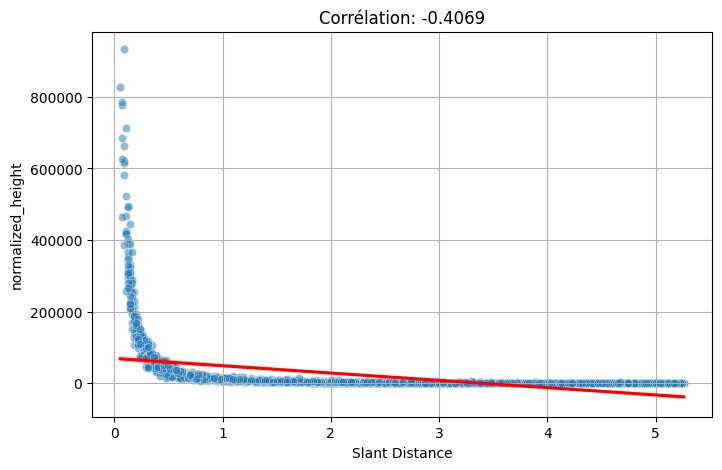

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Charger les données
df = pd.read_csv("output.csv")

# Vérifier les premières lignes
print(df.head())

# Vérifier s'il y a des valeurs manquantes
df = df.dropna(subset=["slant_distance", "bbox_area"])

# Calcul du coefficient de corrélation de Pearson
corr, p_value = pearsonr(df["slant_distance"], df["bbox_area"])

print(f"Coefficient de corrélation de Pearson: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Création du scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["slant_distance"], y=df["bbox_area"], alpha=0.5)

# Ajout de la ligne de tendance (regression)
sns.regplot(x=df["slant_distance"], y=df["bbox_area"], scatter=False, color='red')

plt.xlabel("Slant Distance")
plt.ylabel("normalized_height")
plt.title(f"Corrélation: {corr:.4f}")
plt.grid(True)
plt.show()


Relation négative (donc au fur et à mesure que la slant_distance augment l'aire de la boite a tendance à diminuer), mais la relation est pas linéaire (plus exponentielle d'ailleurs ?)

Coefficient de corrélation de Pearson: -0.4069
P-value: 0.0000


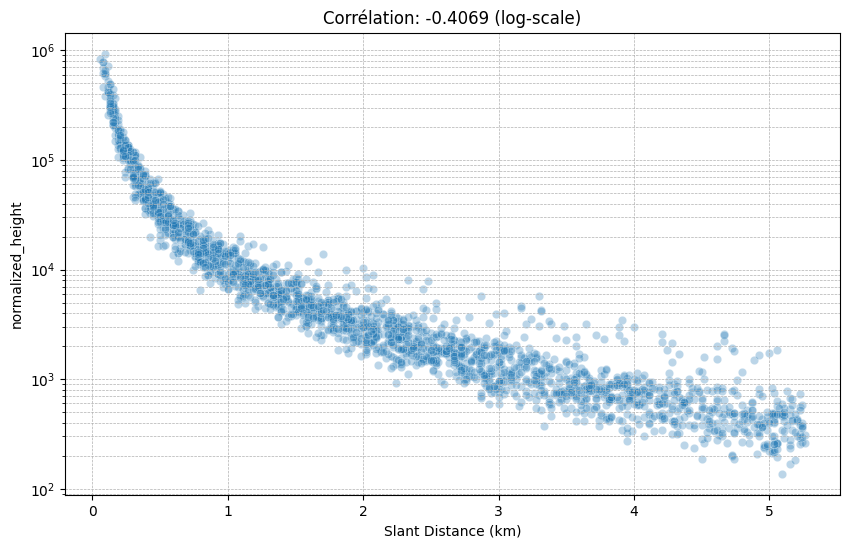

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Charger les données
df = pd.read_csv("output.csv")

# Supprimer les valeurs manquantes
df = df.dropna(subset=["slant_distance", "bbox_area"])

# Calcul du coefficient de corrélation de Pearson
corr, p_value = pearsonr(df["slant_distance"], df["bbox_area"])

print(f"Coefficient de corrélation de Pearson: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Création du scatter plot avec échelle logarithmique
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df["slant_distance"], y=df["bbox_area"], alpha=0.3)

# Ajout de la ligne de tendance avec régression (sans points)
#sns.regplot(x=df["slant_distance"], y=df["bbox_area"], scatter=False, color='red')

# Appliquer une échelle logarithmique sur bbox_area
plt.yscale("log")

plt.xlabel("Slant Distance (km)")
plt.ylabel("normalized_height")
plt.title(f"Corrélation: {corr:.4f} (log-scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Affichage du graphique
plt.show()


- Plus la slant_distance augmente, plus la bbox_area diminue.
- Confoirmation qu'à mesure que l'objet s'éloigne, la bounding box capturée devient plus petite.

- [0-1] km → bbox_area est très grand, avec une médiane à 44,975 px² et un max énorme de 2,7M px².
- [1-2] km → Forte baisse, médiane à 9,240 px².
- [2-3] km → Encore une réduction, médiane à 4,264 px².
- [3-4] km → La plus petite taille, médiane à 2,546 px².

In [20]:
df.to_csv("output_with_range.csv")